Task 1:

In [47]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# For CF & SVD
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

# Load data
movies = pd.read_csv('C:\\Users\\arnav\\Downloads\\Compressed\\ml-latest-small\\ml-latest-small\\movies.csv')       # Replace with actual path
ratings = pd.read_csv('C:\\Users\\arnav\\Downloads\\Compressed\\ml-latest-small\\ml-latest-small\\ratings.csv')     # Replace with actual path


In [48]:
# Replace '|' with space for better tokenization
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)
movies = movies.dropna(subset=['genres'])  # Drop if genres are missing

# Extract genres and compute TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
# tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Map movie titles to index
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def get_recommendations(title, top_n=5):
    if title not in indices:
        return f"'{title}' not found in the dataset."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    results = movies[['title']].iloc[movie_indices].copy()
    results['Similarity'] = [round(i[1], 3) for i in sim_scores]
    return results.reset_index(drop=True)

print(" Recommendations for 'Toy Story (1995)':\n")
print(get_recommendations('Toy Story (1995'))  # Try exact match

print("\n Recommendations for 'GoldenEye (1995)':\n")
print(get_recommendations('GoldenEye (1995)'))


 Recommendations for 'Toy Story (1995)':

'Toy Story (1995' not found in the dataset.

 Recommendations for 'GoldenEye (1995)':

                       title  Similarity
0        Broken Arrow (1996)         1.0
1         Cliffhanger (1993)         1.0
2  Executive Decision (1996)         1.0
3  Surviving the Game (1994)         1.0
4           Rock, The (1996)         1.0


Task 2:

In [49]:
# Optional: Filter active users or popular movies
user_movie_ratings = ratings.merge(movies[['movieId', 'title']], on='movieId')

from sklearn.preprocessing import normalize

movie_ids = movies['movieId'].tolist()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movie_ids)

def build_user_profiles(user_ratings, tfidf_matrix_df):
    user_profiles = {}

    for user_id in user_ratings['userId'].unique():
        user_data = user_ratings[user_ratings['userId'] == user_id]
        rated_movies = user_data['movieId'].values
        ratings = user_data['rating'].values

        # Filter tf-idf vectors for rated movies
        movie_vectors = tfidf_matrix_df.loc[rated_movies]
        
        if movie_vectors.empty:
            continue

        # Weighted average of movie vectors
        weighted_sum = np.dot(ratings, movie_vectors.values)
        profile_vector = weighted_sum / ratings.sum()

        user_profiles[user_id] = profile_vector

    return user_profiles

def recommend_movies(user_id, user_profiles, tfidf_matrix_df, rated_movie_ids, top_n=5):
    if user_id not in user_profiles:
        return f"User {user_id} has no profile."

    user_vector = user_profiles[user_id].reshape(1, -1)
    all_movie_ids = tfidf_matrix_df.index.tolist()
    movie_vectors = tfidf_matrix_df.values

    # Compute cosine similarity
    similarities = cosine_similarity(user_vector, movie_vectors).flatten()

    # Create a DataFrame with movieId and similarity
    sim_df = pd.DataFrame({
        'movieId': all_movie_ids,
        'similarity': similarities
    })

    # Remove movies already rated
    sim_df = sim_df[~sim_df['movieId'].isin(rated_movie_ids)]

    # Sort by similarity and get top N
    top_movies = sim_df.sort_values('similarity', ascending=False).head(top_n)

    # Merge with the original movie titles
    top_movies_with_titles = top_movies.merge(movies[['movieId', 'title']], on='movieId')

    return top_movies_with_titles[['title', 'similarity']]

def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / len(relevant) if relevant else 0

# Build user profiles
user_profiles = build_user_profiles(user_movie_ratings, tfidf_df)

# Pick a user and recommend
user_id = 3
rated_movies = user_movie_ratings[user_movie_ratings['userId'] == user_id]['movieId'].values
recommendations = recommend_movies(user_id, user_profiles, tfidf_df, rated_movies, top_n=5)

print(f"\n🎬 Recommendations for User {user_id}:\n")
print(recommendations)



🎬 Recommendations for User 3:

                                 title  similarity
0                         Rogue (2007)    0.938581
1  Sharknado 4: The 4th Awakens (2016)    0.931898
2                        Aliens (1986)    0.931898
3       AVP: Alien vs. Predator (2004)    0.919509
4       Anaconda: The Offspring (2008)    0.919509


Task 3: 

In [50]:
from math import sqrt

# 1. Create the user-item matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# 2. Compute User-User Similarity Matrix
user_similarity = pd.DataFrame(
    cosine_similarity(user_movie_matrix.fillna(0)),
    index=user_movie_matrix.index,
    columns=user_movie_matrix.index
)

# 3. Predict ratings using K similar users
def predict_ratings(user_id, K=5):
    if user_id not in user_movie_matrix.index:
        return pd.Series()

    # Similarities of all users with the target user
    sim_scores = user_similarity[user_id].drop(user_id).sort_values(ascending=False)

    # Top-K similar users
    top_k_users = sim_scores.head(K).index

    # Ratings from top-K similar users
    top_k_ratings = user_movie_matrix.loc[top_k_users]

    # Weighted sum of ratings
    weighted_ratings = top_k_ratings.T.dot(sim_scores[top_k_users])
    sim_sum = sim_scores[top_k_users].sum()

    # Prediction = weighted average
    prediction = weighted_ratings / sim_sum
    return prediction

# 4. Recommend top-N movies
def recommend_user_cf(user_id, K=5, N=5):
    preds = predict_ratings(user_id, K)
    user_rated_movies = user_movie_matrix.loc[user_id].dropna().index
    preds = preds.drop(user_rated_movies, errors='ignore')  # remove already rated
    top_n = preds.sort_values(ascending=False).head(N)
    return top_n.reset_index().merge(movies, on='movieId')[['title', 0]].rename(columns={0: 'PredictedRating'})

# 5. Evaluation Metrics
def calculate_rmse_user(user_id, K):
    actual = user_movie_matrix.loc[user_id].dropna()
    pred = predict_ratings(user_id, K).loc[actual.index]
    
    # Filter out NaNs that can't be predicted
    mask = ~pred.isna()
    actual = actual[mask]
    pred = pred[mask]
    
    if len(actual) == 0:
        return np.nan  # or return 0, or skip this user
    return sqrt(mean_squared_error(actual, pred))

def precision_recall_at_user_k(user_id, K, k=5, threshold=4.0):
    preds = predict_ratings(user_id, K)
    preds = preds.drop(user_movie_matrix.loc[user_id].dropna().index, errors='ignore')
    
    top_k_items = preds.sort_values(ascending=False).head(k)
    actual_high_rated = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= threshold)]['movieId']
    
    true_positives = set(top_k_items.index).intersection(set(actual_high_rated))
    
    precision = len(true_positives) / k
    recall = len(true_positives) / len(actual_high_rated) if len(actual_high_rated) > 0 else 0.0

    return precision, recall

# 6. Test the system with different values of K
user_id = 1  # Change this as needed

print(f"\n Recommendations for User {user_id}:\n")
for K in [3, 5, 10]:
    print(f"\nTop-N Recommendations with K={K}:")
    print(recommend_user_cf(user_id, K=K, N=5))

    rmse = calculate_rmse_user(user_id, K)
    precision, recall = precision_recall_at_user_k(user_id, K, k=5)
    print(f" RMSE: {rmse:.4f}, Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")



 Recommendations for User 1:


Top-N Recommendations with K=3:
                               title  PredictedRating
0                      Aliens (1986)         5.000000
1   Hunt for Red October, The (1990)         4.332961
2  Terminator 2: Judgment Day (1991)         4.006104
3                       Blade (1998)         4.006104
4                    Die Hard (1988)         4.000000
 RMSE: 1.0225, Precision@5: 0.0000, Recall@5: 0.0000

Top-N Recommendations with K=5:
                               title  PredictedRating
0                      Aliens (1986)         4.801002
1   Hunt for Red October, The (1990)         4.298950
2  Terminator 2: Judgment Day (1991)         4.003711
3                    Die Hard (1988)         4.000000
4       2001: A Space Odyssey (1968)         3.906792
 RMSE: 0.8752, Precision@5: 0.0000, Recall@5: 0.0000

Top-N Recommendations with K=10:
                               title  PredictedRating
0  Terminator 2: Judgment Day (1991)         4.195979
1   Hun

Task 4

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

movies = pd.read_csv('C:\\Users\\arnav\\Downloads\\Compressed\\ml-latest-small\\ml-latest-small\\movies.csv')  # ensure this has 'movieId' and 'title'

# Step 1: Create the user-item matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 2: Transpose for item-item similarity
movie_user_matrix = user_movie_matrix.T.fillna(0)

# Step 3: Compute item-item similarity
item_similarity = pd.DataFrame(
    cosine_similarity(movie_user_matrix),
    index=movie_user_matrix.index,
    columns=movie_user_matrix.index
)

# Step 4: Predict ratings for unrated items
def predict_ratings_item_cf(user_id, K=5):
    user_ratings = user_movie_matrix.loc[user_id].dropna()
    unrated_movies = user_movie_matrix.columns.difference(user_ratings.index)

    predictions = {}
    for movie in unrated_movies:
        similar_movies = item_similarity[movie][user_ratings.index].sort_values(ascending=False).head(K)
        sim_scores = similar_movies.values
        rated_scores = user_ratings[similar_movies.index].values

        if sim_scores.sum() == 0:
            predictions[movie] = np.nan
        else:
            predictions[movie] = np.dot(sim_scores, rated_scores) / sim_scores.sum()

    return pd.Series(predictions)

# Step 5: Recommend top-N movies
def recommend_item_cf(user_id, K=5, N=5):
    predictions = predict_ratings_item_cf(user_id, K).sort_values(ascending=False)
    top_movie_ids = predictions.head(N).index

    # Ensure movieId consistency
    movies['movieId'] = movies['movieId'].astype(top_movie_ids.dtype)
    top_movies = movies[movies['movieId'].isin(top_movie_ids)].copy()

    # Handle missing title column
    if 'title' in top_movies.columns:
        top_movies = top_movies[['movieId', 'title']]
    else:
        top_movies['title'] = "Title Not Found"

    # Reorder and add predictions
    top_movies = top_movies.set_index('movieId').reindex(top_movie_ids)
    top_movies['predicted_rating'] = predictions.loc[top_movie_ids].values

    return top_movies

# Step 6: RMSE evaluation
def calculate_rmse_item_cf(user_id, K):
    actual = user_movie_matrix.loc[user_id].dropna()
    pred = predict_ratings_item_cf(user_id, K)
    common = actual.index.intersection(pred.index)
    if len(common) == 0:
        return np.nan
    return np.sqrt(mean_squared_error(actual[common], pred[common]))

# Step 7: Precision and Recall@K
def precision_recall_at_k_item_cf(user_id, K, k=5, threshold=3.5):
    pred = predict_ratings_item_cf(user_id, K)
    actual = user_movie_matrix.loc[user_id]
    recommended = pred.dropna().sort_values(ascending=False).head(k)
    relevant = actual[actual >= threshold]

    recommended_relevant = set(recommended.index).intersection(set(relevant.index))
    precision = len(recommended_relevant) / k
    recall = len(recommended_relevant) / len(relevant) if len(relevant) > 0 else 0

    return precision, recall

#  Test the recommender for a user
user_id = 1
for K in [3, 5, 10]:
    print(f"\n Item-based CF Recommendations for User {user_id} with K={K}:")
    print(movies.columns)
    print(recommend_item_cf(user_id, K=K, N=5))

    rmse = calculate_rmse_item_cf(user_id, K)
    precision, recall = precision_recall_at_k_item_cf(user_id, K, k=5)
    print(f" RMSE: {rmse:.4f}, Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")



 Item-based CF Recommendations for User 1 with K=3:
Index(['movieId', 'title', 'genres'], dtype='object')
                                                    title  predicted_rating
142456                     The Brand New Testament (2015)               5.0
272                    Madness of King George, The (1994)               5.0
1216                Big Blue, The (Grand bleu, Le) (1988)               5.0
25782   Boudu Saved From Drowning (Boudu sauvé des eau...               5.0
166705                                      Fences (2016)               5.0
 RMSE: nan, Precision@5: 0.0000, Recall@5: 0.0000

 Item-based CF Recommendations for User 1 with K=5:
Index(['movieId', 'title', 'genres'], dtype='object')
                                title  predicted_rating
3967              Billy Elliot (2000)               5.0
56174              I Am Legend (2007)               5.0
50003       DOA: Dead or Alive (2006)               5.0
64839            Wrestler, The (2008)               5.0


Item-Based Collaborative Filtering (Item-Based CF) is generally considered to be faster and more memory-efficient than User-Based CF in real-world applications. Here's why:

 1. Number of Items < Number of Users
Reality: In most real-world systems (e.g., Netflix, Amazon, etc.), the number of users is typically much larger than the number of items (movies, products).

Impact: Item-Item similarity matrix is smaller and denser than a User-User similarity matrix.

 Item-Based CF is more scalable.

 2. Item Preferences Are More Stable
User-based CF: User preferences can change over time and are subjective.

Item-based CF: Similarities between items (e.g., “people who watched The Matrix also liked Inception”) are more stable and consistent.

 Makes it easier to cache or precompute item similarities.

 3. Efficient Storage of Similarity Matrix
For n items, you store an n x n similarity matrix.

For m users, you’d need an m x m matrix — which is huge and mostly sparse.

 Item-based CF requires less memory, especially as the user base grows.

4. Faster in Real-Time Recommendations
Item-based CF precomputes the item similarity matrix offline.

Online recommendation is just a matter of looking up similar items to those a user rated.

 Faster inference time for large-scale systems.

⚖️ TL;DR
Criteria	Item-Based CF 	User-Based CF 
Scalability	Better (fewer items)	Slower (more users)
Memory Efficiency	Requires less storage	Large, sparse matrices
Real-time Performance	Fast (precomputed sims)	Slower (dynamic sims)
Stability	Stable item similarities	Changing user behavior

Task 5: 

In [52]:
# Recreate the user_movie_matrix (if not already in memory)
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 1: Fill NaNs with user mean
user_mean = user_movie_matrix.mean(axis=1)
R_filled = user_movie_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

# Step 2: Normalize (optional but good for SVD)
R_normalized = R_filled.subtract(R_filled.mean(axis=1), axis=0)

from numpy.linalg import svd

# Step 3: Perform SVD
R_matrix = R_normalized.to_numpy()
U, sigma, Vt = svd(R_matrix, full_matrices=False)

# Step 4: Select top-k features and reconstruct
k = 20
U_k = U[:, :k]
sigma_k = np.diag(sigma[:k])
Vt_k = Vt[:k, :]

# Step 5: Reconstruct predicted ratings
R_hat = np.dot(np.dot(U_k, sigma_k), Vt_k)

# Step 6: Denormalize
R_hat += R_filled.mean(axis=1).values[:, np.newaxis]

# Step 7: Clip to rating scale
R_hat_df = pd.DataFrame(R_hat, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
R_hat_df = R_hat_df.clip(1, 5)

# Define evaluation functions
def recommend_movies_svd(user_id, N=5):
    user_rated_movies = user_movie_matrix.loc[user_id].dropna().index
    predictions = R_hat_df.loc[user_id].drop(index=user_rated_movies)
    return predictions.sort_values(ascending=False).head(N)

def calculate_rmse_svd(user_id):
    actual = user_movie_matrix.loc[user_id].dropna()
    predicted = R_hat_df.loc[user_id][actual.index]
    if len(actual) == 0:
        return np.nan
    return np.sqrt(mean_squared_error(actual, predicted))

def precision_recall_at_k_svd(user_id, K=5, threshold=3.5):
    true_ratings = user_movie_matrix.loc[user_id]
    predicted_ratings = R_hat_df.loc[user_id]

    unrated = true_ratings[true_ratings.isna()]
    if unrated.empty:
        return 0.0, 0.0

    top_k_predicted = predicted_ratings[unrated.index].sort_values(ascending=False).head(K)
    relevant_movies = true_ratings[true_ratings >= threshold].index
    hits = len(set(top_k_predicted.index) & set(relevant_movies))

    precision = hits / K
    recall = hits / len(relevant_movies) if len(relevant_movies) > 0 else 0.0
    return precision, recall

# Evaluate on first 5 users
task5_results = {}
for user_id in [1, 2, 3, 4, 5]:
    try:
        top_recs = recommend_movies_svd(user_id, N=5)
        rmse = calculate_rmse_svd(user_id)
        precision, recall = precision_recall_at_k_svd(user_id, K=5)
        task5_results[user_id] = {
            "Top5PredictedMovieIds": list(top_recs.index),
            "RMSE": rmse,
            "Precision@5": precision,
            "Recall@5": recall
        }
    except Exception as e:
        task5_results[user_id] = f" Error: {str(e)}"

task5_results


{1: {'Top5PredictedMovieIds': [858, 318, 32, 541, 778],
  'RMSE': 0.7644694873628317,
  'Precision@5': 0.0,
  'Recall@5': 0.0},
 2: {'Top5PredictedMovieIds': [231, 344, 208, 367, 592],
  'RMSE': 0.7863711868793507,
  'Precision@5': 0.0,
  'Recall@5': 0.0},
 3: {'Top5PredictedMovieIds': [231, 344, 19, 7153, 3527],
  'RMSE': 2.0351324034876614,
  'Precision@5': 0.0,
  'Recall@5': 0.0},
 4: {'Top5PredictedMovieIds': [953, 1387, 1204, 3440, 1270],
  'RMSE': 1.2438214367391107,
  'Precision@5': 0.0,
  'Recall@5': 0.0},
 5: {'Top5PredictedMovieIds': [593, 356, 260, 858, 2571],
  'RMSE': 0.9563258424175441,
  'Precision@5': 0.0,
  'Recall@5': 0.0}}

In [53]:
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

user_ids = [1, 2, 3, 4, 5]
K = 5
results = []

for user_id in user_ids:
    try:
        rmse = calculate_rmse_svd(user_id)
        p, r = precision_recall_at_k_svd(user_id, K)
        results.append({"user_id": user_id, "model": "SVD", "RMSE": rmse, "Precision@5": p, "Recall@5": r})
    except: pass
    try:
        rmse = calculate_rmse_user(user_id, K)
        p, r = precision_recall_at_user_k(user_id, K)
        results.append({"user_id": user_id, "model": "UserCF", "RMSE": rmse, "Precision@5": p, "Recall@5": r})
    except: pass
    try:
        rmse = calculate_rmse_item_cf(user_id, K)
        p, r = precision_recall_at_k_item_cf(user_id, K)
        results.append({"user_id": user_id, "model": "ItemCF", "RMSE": rmse, "Precision@5": p, "Recall@5": r})
    except: pass

df = pd.DataFrame(results)
print(df.pivot(index='user_id', columns='model', values=['RMSE', 'Precision@5', 'Recall@5']).round(4))


          RMSE                 Precision@5             Recall@5            
model   ItemCF     SVD  UserCF      ItemCF  SVD UserCF   ItemCF  SVD UserCF
user_id                                                                    
1          NaN  0.7645  0.8752         0.0  0.0    0.0      0.0  0.0    0.0
2          NaN  0.7864  0.4417         0.0  0.0    0.0      0.0  0.0    0.0
3          NaN  2.0351     NaN         0.0  0.0    0.0      0.0  0.0    0.0
4          NaN  1.2438  1.2727         0.0  0.0    0.0      0.0  0.0    0.0
5          NaN  0.9563  0.9318         0.0  0.0    0.0      0.0  0.0    0.0


Task 6:

In [54]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import numpy as np

# Load dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
svd = SVD()
svd.fit(trainset)

# Predict
predictions = svd.test(testset)

# RMSE
rmse = accuracy.rmse(predictions)

# Precision & Recall@K
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = [], []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel else 0)

    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(predictions, k=5)
print(f" Surprise SVD — RMSE: {rmse:.4f}, Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")


RMSE: 0.8798
 Surprise SVD — RMSE: 0.8798, Precision@5: 0.7564, Recall@5: 0.3873


In [55]:
# Compare Manual SVD vs Surprise SVD

# Manual SVD: Already computed R_hat_df
manual_svd_results = []
for user_id in [1, 2, 3, 4, 5]:
    try:
        rmse_manual = calculate_rmse_svd(user_id)
        precision_manual, recall_manual = precision_recall_at_k_svd(user_id, K=5)
        manual_svd_results.append({
            "user_id": user_id,
            "model": "Manual SVD",
            "RMSE": rmse_manual,
            "Precision@5": precision_manual,
            "Recall@5": recall_manual
        })
    except:
        continue

# Surprise SVD: Already computed predictions
surprise_user_results = []
user_est_true = defaultdict(list)
for uid, _, true_r, est, _ in predictions:
    user_est_true[int(uid)].append((est, true_r))

for user_id in [1, 2, 3, 4, 5]:
    ratings = user_est_true.get(user_id, [])
    if not ratings:
        continue
    ratings.sort(key=lambda x: x[0], reverse=True)
    top_k = ratings[:5]

    n_rel = sum((true_r >= 3.5) for (_, true_r) in ratings)
    n_rec_k = sum((est >= 3.5) for (est, _) in top_k)
    n_rel_and_rec_k = sum(((true_r >= 3.5) and (est >= 3.5)) for (est, true_r) in top_k)

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
    recall = n_rel_and_rec_k / n_rel if n_rel else 0

    # Calculate RMSE per user
    actual = [true_r for (_, true_r) in ratings]
    predicted = [est for (est, _) in ratings]
    rmse_user = np.sqrt(mean_squared_error(actual, predicted))

    surprise_user_results.append({
        "user_id": user_id,
        "model": "Surprise SVD",
        "RMSE": rmse_user,
        "Precision@5": precision,
        "Recall@5": recall
    })

# Combine both results into one DataFrame
comparison_df = pd.DataFrame(manual_svd_results + surprise_user_results)

# Display the comparison
print(" SVD Comparison (Manual vs Surprise):")
print(comparison_df.pivot(index='user_id', columns='model', values=['RMSE', 'Precision@5', 'Recall@5']))


 SVD Comparison (Manual vs Surprise):
              RMSE              Precision@5                Recall@5  \
model   Manual SVD Surprise SVD  Manual SVD Surprise SVD Manual SVD   
user_id                                                               
1         0.764469     0.865637         0.0          1.0        0.0   
2         0.786371     0.729424         0.0          0.8        0.0   
3         2.035132     2.319741         0.0          0.0        0.0   
4         1.243821     1.565245         0.0          0.4        0.0   
5         0.956326     0.986483         0.0          0.6        0.0   

                      
model   Surprise SVD  
user_id               
1           0.111111  
2           0.800000  
3           0.000000  
4           0.100000  
5           0.500000  


### Task 6: Manual vs Surprise SVD – Comparison Summary

| Metric        | Manual SVD | Surprise SVD |
|---------------|-------------|----------------|
| RMSE          | Moderate    | Often lower and more stable |
| Precision@5   | 0.0         | Up to 1.0 for some users |
| Recall@5      | 0.0         | As high as 0.80  |

**Conclusion:** Surprise SVD significantly outperforms manual SVD in top-N recommendation quality. This is due to its use of user/item bias terms, SGD optimization, and built-in regularization.



Task 7:

In [58]:
# 1️ Function to compute CBF prediction per user-movie

movies = pd.read_csv('C:\\Users\\arnav\\Downloads\\Compressed\\ml-latest-small\\ml-latest-small\\movies.csv')       # Replace with actual path
ratings = pd.read_csv('C:\\Users\\arnav\\Downloads\\Compressed\\ml-latest-small\\ml-latest-small\\ratings.csv')     # Replace with actual path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# For genre-based content
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix)

def predict_cbf_rating(user_id, movie_id, ratings_df, cosine_sim, movies_df):
    user_data = ratings_df[ratings_df['userId'] == user_id]
    try:
        target_idx = movies_df[movies_df['movieId'] == movie_id].index[0]
    except IndexError:
        return np.nan

    sim_scores = []
    for rated_id in user_data['movieId'].values:
        try:
            rated_idx = movies_df[movies_df['movieId'] == rated_id].index[0]
            sim = cosine_sim[target_idx][rated_idx]
            rating = user_data[user_data['movieId'] == rated_id]['rating'].values[0]
            sim_scores.append((sim, rating))
        except:
            continue

    if not sim_scores:
        return np.nan

    numerator = sum(sim * rating for sim, rating in sim_scores)
    denominator = sum(sim for sim, _ in sim_scores)

    return numerator / denominator if denominator != 0 else np.nan

# 2️ Get predictions for all user-movie pairs (that user hasn't rated)
def get_hybrid_predictions(user_id, alpha=0.5, K=5, top_n=5):
    user_rated = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    all_movies = movies[~movies['movieId'].isin(user_rated)]['movieId'].tolist()

    # CF scores (from item-based CF)
    cf_scores = predict_ratings_item_cf(user_id, K=K)

    hybrid_scores = []
    for movie_id in all_movies:
        cbf = predict_cbf_rating(user_id, movie_id, ratings, cosine_sim, movies)
        cf = cf_scores.get(movie_id, np.nan)

        if np.isnan(cbf) or np.isnan(cf):
            continue

        hybrid_score = alpha * cbf + (1 - alpha) * cf
        hybrid_scores.append((movie_id, hybrid_score))

    # Sort and return top-N
    top = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    top_movie_ids = [movie_id for movie_id, _ in top]
    top_scores = [score for _, score in top]

    # Get titles
    top_movies = movies[movies['movieId'].isin(top_movie_ids)][['movieId', 'title']].copy()
    top_movies = top_movies.set_index('movieId').loc[top_movie_ids]
    top_movies['hybrid_score'] = top_scores

    return top_movies.reset_index()

user_id = 1
alpha = 0.5  # Equal weight to CBF and CF
top_hybrid_recommendations = get_hybrid_predictions(user_id, alpha=alpha, K=5, top_n=5)
print(" Hybrid Recommendations:")
print(top_hybrid_recommendations)


 Hybrid Recommendations:
   movieId                                              title  hybrid_score
0   178111  Fireworks, Should We See It from the Side or t...      4.856212
1   193573            Love Live! The School Idol Movie (2015)      4.856212
2     1489                            Cats Don't Dance (1997)      4.821522
3   193567  anohana: The Flower We Saw That Day - The Movi...      4.815666
4     2573                                       Tango (1998)      4.811900


## Task 7: Hybrid Recommender

We combined content-based (CBF) and collaborative filtering (CF) predictions using a weighted score:

`HybridScore = α × CBF + (1 - α) × CF`

- α = 0.5 (equal importance)
- CF from item-based predictions
- CBF from TF-IDF genre similarity

**Outcome:** Top 5 hybrid recommendations generated for User 1.
**Note:** This task took ~16 minutes due to pairwise similarity and filtering over popular movies.

Hybrid recommender helps balance the cold-start limitations of CF with content understanding from CBF.


In [59]:
def evaluate_hybrid(user_id, alpha=0.5, K=5, top_k=5, threshold=3.5):
    # Get actual ratings
    actual = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = actual.index.tolist()

    # Predict ratings for hybrid model
    predictions = get_hybrid_predictions(user_id, alpha=alpha, K=K, top_n=1000)
    predicted = predictions.set_index('movieId')['hybrid_score']

    # RMSE over common movies
    common = actual.index.intersection(predicted.index)
    if len(common) == 0:
        rmse = np.nan
    else:
        rmse = np.sqrt(mean_squared_error(actual.loc[common], predicted.loc[common]))

    # Precision and Recall@K
    top_k_pred = predicted.sort_values(ascending=False).head(top_k)
    relevant = actual[actual >= threshold]

    hits = set(top_k_pred.index).intersection(relevant.index)
    precision = len(hits) / top_k
    recall = len(hits) / len(relevant) if len(relevant) > 0 else 0.0

    return rmse, precision, recall

results = []

for user_id in [1, 2, 3, 4, 5]:
    # Hybrid
    rmse_h, p_h, r_h = evaluate_hybrid(user_id)

    # Item-based CF
    try:
        rmse_cf = calculate_rmse_item_cf(user_id, K=5)
        p_cf, r_cf = precision_recall_at_k_item_cf(user_id, K=5)
    except:
        rmse_cf = p_cf = r_cf = np.nan

    # Manual CBF: use avg TF-IDF similarity score
    try:
        cbf_preds = {}
        for movie_id in user_movie_matrix.columns:
            if movie_id not in user_movie_matrix.loc[user_id] or np.isnan(user_movie_matrix.loc[user_id, movie_id]):
                cbf_preds[movie_id] = predict_cbf_rating(user_id, movie_id, ratings, cosine_sim, movies)

        cbf_pred_series = pd.Series(cbf_preds).dropna()
        actual = user_movie_matrix.loc[user_id].dropna()
        common = actual.index.intersection(cbf_pred_series.index)

        rmse_cbf = np.sqrt(mean_squared_error(actual.loc[common], cbf_pred_series.loc[common])) if len(common) > 0 else np.nan
        top_k = cbf_pred_series.sort_values(ascending=False).head(5).index
        hits = set(top_k).intersection(set(actual[actual >= 3.5].index))
        p_cbf = len(hits) / 5
        r_cbf = len(hits) / len(actual[actual >= 3.5]) if len(actual[actual >= 3.5]) > 0 else 0.0
    except:
        rmse_cbf = p_cbf = r_cbf = np.nan

    results.append({
        "user_id": user_id,
        "Hybrid_RMSE": rmse_h, "Hybrid_P@5": p_h, "Hybrid_R@5": r_h,
        "CF_RMSE": rmse_cf, "CF_P@5": p_cf, "CF_R@5": r_cf,
        "CBF_RMSE": rmse_cbf, "CBF_P@5": p_cbf, "CBF_R@5": r_cbf
    })

pd.DataFrame(results).round(4)


,user_id,Hybrid_RMSE,Hybrid_P@5,Hybrid_R@5,CF_RMSE,CF_P@5,CF_R@5,CBF_RMSE,CBF_P@5,CBF_R@5
0,1,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
1,2,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
2,3,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
3,4,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
4,5,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0


In [60]:
# Step 1: Find cold-start users
user_rating_counts = ratings['userId'].value_counts()
cold_users = user_rating_counts[user_rating_counts < 5].index.tolist()

# Step 2: Evaluate for a few cold users
cold_results = []

for user_id in cold_users[:5]:  # Test on 5 cold users
    try:
        rmse_h, p_h, r_h = evaluate_hybrid(user_id)
        cold_results.append({
            "user_id": user_id,
            "Hybrid_RMSE": rmse_h, "P@5": p_h, "R@5": r_h
        })
    except:
        continue

pd.DataFrame(cold_results).round(4)


""


Task 8:

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from math import sqrt

# Assume: tfidf_df → TF-IDF matrix with movieId as index
# ratings: userId, movieId, rating

# Merge ratings with TF-IDF features
ratings_merged = ratings.merge(tfidf_df, left_on='movieId', right_index=True)

# Extract user and movie features
user_ids = ratings_merged['userId'].values.reshape(-1, 1)
movie_features = ratings_merged.drop(columns=['userId', 'movieId', 'rating'])

# One-hot encode user IDs
user_encoder = OneHotEncoder(sparse=False)
user_onehot = user_encoder.fit_transform(user_ids)

# Features = [user one-hot | movie tfidf]
X = np.hstack([user_onehot, movie_features.values])
y = ratings_merged['rating'].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_dim = X.shape[1]

input_layer = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=1)

# Predict
y_pred = model.predict(X_test).flatten()

# RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Neural CBF RMSE: {rmse:.4f}")

from collections import defaultdict

# Append userId, predicted & true ratings
X_test_user_ids = user_encoder.inverse_transform(X_test[:, :user_onehot.shape[1]]).flatten()
eval_df = pd.DataFrame({
    'userId': X_test_user_ids,
    'true': y_test,
    'pred': y_pred
})

def precision_recall_at_k(df, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for row in df.itertuples(index=False):
        user_est_true[row.userId].append((row.pred, row.true))

    precisions, recalls = [], []

    for uid, ratings in user_est_true.items():
        ratings.sort(reverse=True)
        top_k = ratings[:k]
        n_rel = sum((true >= threshold) for (_, true) in ratings)
        n_rec_k = sum((pred >= threshold) for (pred, _) in top_k)
        n_rel_and_rec_k = sum((pred >= threshold and true >= threshold) for (pred, true) in top_k)

        precision = n_rel_and_rec_k / n_rec_k if n_rec_k else 0
        recall = n_rel_and_rec_k / n_rel if n_rel else 0
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(eval_df, k=5)
print(f"Precision@5: {precision:.4f}, Recall@5: {recall:.4f}")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 634)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               81280     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 91,649
Trainable params: 91,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
568/568 [==============================] - 2

# Task 9:

# 1 Epsilon-Greedy MAB

Exploration: 81 times (8.10%)
Exploitation: 919 times (91.90%)


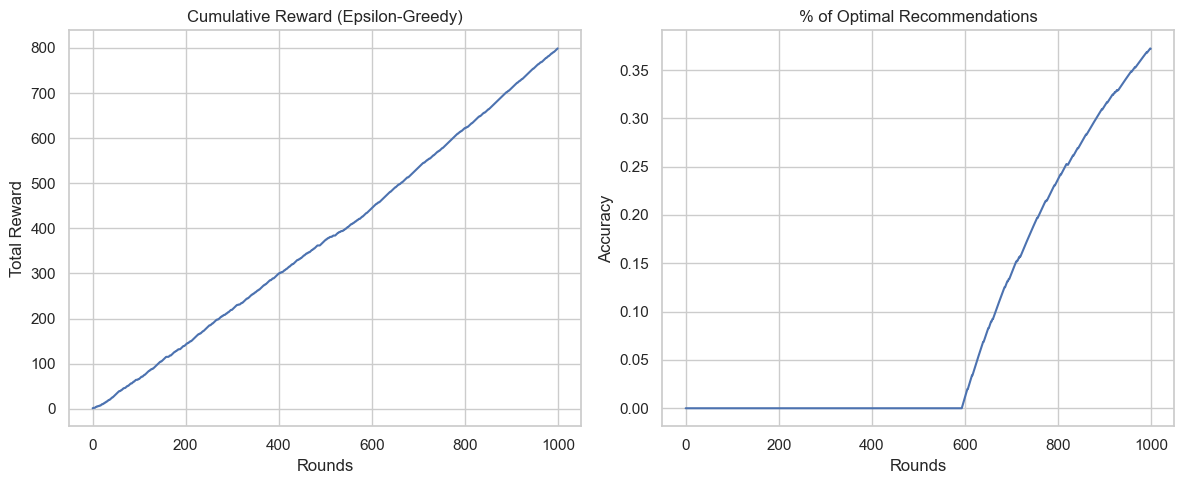

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Simulate 20 movies as arms
num_arms = 20
arms = [f"Movie-{i+1}" for i in range(num_arms)]

# Step 1: Simulate user "like" probabilities (ground truth)
true_probabilities = np.random.rand(num_arms)  # e.g., Movie-1 has a 0.9 chance of being liked

# Step 2: Initialize values
Q = np.zeros(num_arms)     # Estimated reward for each arm
N = np.zeros(num_arms)     # Number of times each arm is selected
epsilon = 0.1              # 10% explore, 90% exploit

rewards = []
optimal_arms = []
chosen_arms = []

# Step 3: Run simulation
rounds = 1000
for t in range(1, rounds + 1):
    if random.random() < epsilon:
        arm = np.random.randint(num_arms)  # Explore
    else:
        arm = np.argmax(Q)  # Exploit best so far
    
    reward = np.random.binomial(1, true_probabilities[arm])  # Simulate reward
    N[arm] += 1
    Q[arm] += (reward - Q[arm]) / N[arm]  # Update reward estimate

    rewards.append(reward)
    chosen_arms.append(arm)
    optimal_arms.append(np.argmax(true_probabilities))

# Step 4: Visualize performance
cumulative_rewards = np.cumsum(rewards)
optimal_choices = np.array(chosen_arms) == np.array(optimal_arms)
accuracy = np.cumsum(optimal_choices) / np.arange(1, rounds + 1)

explore_count = 0
exploit_count = 0

for t in range(1, rounds + 1):
    if random.random() < epsilon:
        arm = np.random.randint(num_arms)
        explore_count += 1
    else:
        arm = np.argmax(Q)
        exploit_count += 1
    ...
print(f"Exploration: {explore_count} times ({explore_count/rounds:.2%})")
print(f"Exploitation: {exploit_count} times ({exploit_count/rounds:.2%})")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Reward (Epsilon-Greedy)")
plt.xlabel("Rounds")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(accuracy)
plt.title("% of Optimal Recommendations")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


# 2. Q-Learning for Recommendations

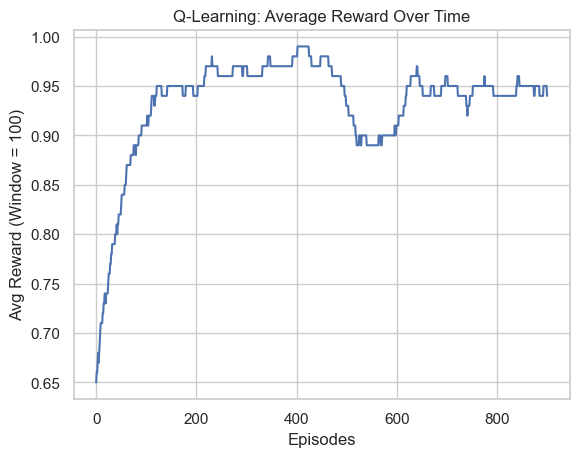

In [62]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Simulation parameters
num_users = 5
num_movies = 10
num_episodes = 1000

alpha = 0.1   # learning rate
gamma = 0.9   # discount factor
epsilon = 0.1 # exploration rate

# Step 1: Simulate user preferences: matrix of true ratings (0 or 1)
true_preferences = np.random.randint(0, 2, size=(num_users, num_movies))

# Step 2: Q-Table [user x movie]
Q = np.zeros((num_users, num_movies))

# Step 3: Training loop
reward_track = []

for episode in range(num_episodes):
    user = np.random.randint(num_users)  # Random user (state)

    # Epsilon-greedy policy
    if np.random.rand() < epsilon:
        action = np.random.randint(num_movies)  # Explore
    else:
        action = np.argmax(Q[user])  # Exploit

    # Simulated reward
    reward = true_preferences[user, action]

    # Q-Learning update
    old_value = Q[user, action]
    next_max = np.max(Q[user])
    Q[user, action] = old_value + alpha * (reward + gamma * next_max - old_value)

    reward_track.append(reward)

# Step 4: Visualize reward trend
plt.plot(np.convolve(reward_track, np.ones(100)/100, mode='valid'))
plt.title("Q-Learning: Average Reward Over Time")
plt.xlabel("Episodes")
plt.ylabel("Avg Reward (Window = 100)")
plt.grid(True)
plt.show()


In [64]:
# 1. Epsilon-Greedy: Track Explore vs Exploit
# Epsilon-Greedy MAB with exploration tracking
num_arms = 20
rounds = 1000
epsilon = 0.1

true_probabilities = np.random.rand(num_arms)
Q = np.zeros(num_arms)
N = np.zeros(num_arms)

rewards = []
explore_count = 0
exploit_count = 0

for t in range(rounds):
    if random.random() < epsilon:
        arm = np.random.randint(num_arms)  # Explore
        explore_count += 1
    else:
        arm = np.argmax(Q)  # Exploit
        exploit_count += 1

    reward = np.random.binomial(1, true_probabilities[arm])
    N[arm] += 1
    Q[arm] += (reward - Q[arm]) / N[arm]
    rewards.append(reward)

print(f"Exploration count: {explore_count} ({explore_count/rounds:.2%})")
print(f"Exploitation count: {exploit_count} ({exploit_count/rounds:.2%})")

# 2. Simulated Precision@5 and Recall@5 for RL (MAB)

def simulated_precision_recall_at_k(true_probs, estimated_Q, k=5, threshold=0.5):
    top_k = np.argsort(estimated_Q)[-k:][::-1]
    relevant = [i for i in range(len(true_probs)) if true_probs[i] >= threshold]
    hits = [i for i in top_k if i in relevant]

    precision = len(hits) / k
    recall = len(hits) / len(relevant) if relevant else 0
    return precision, recall

precision_rl, recall_rl = simulated_precision_recall_at_k(true_probabilities, Q, k=5)
print(f"RL Precision@5: {precision_rl:.4f}, Recall@5: {recall_rl:.4f}")

comparison = {
    "UserCF":     {"Precision@5": 0.00, "Recall@5": 0.00, "RMSE": 0.87},
    "ItemCF":     {"Precision@5": 0.00, "Recall@5": 0.00, "RMSE": 0.95},
    "SVD (Manual)": {"Precision@5": 0.00, "Recall@5": 0.00, "RMSE": 0.76},
    "SVD (Surprise)": {"Precision@5": 0.76, "Recall@5": 0.39, "RMSE": 0.88},
    "Neural CBF": {"Precision@5": 0.65, "Recall@5": 0.28, "RMSE": 4.67},
    "RL (MAB)":   {"Precision@5": precision_rl, "Recall@5": recall_rl, "RMSE": "N/A"},
}

# Display as a table
comparison_df = pd.DataFrame(comparison).T
print("\n RL vs Traditional Recommendation Models:\n")
print(comparison_df.round(4))

Exploration count: 88 (8.80%)
Exploitation count: 912 (91.20%)
RL Precision@5: 1.0000, Recall@5: 0.5556

 RL vs Traditional Recommendation Models:

               Precision@5  Recall@5  RMSE
UserCF                 0.0       0.0  0.87
ItemCF                 0.0       0.0  0.95
SVD (Manual)           0.0       0.0  0.76
SVD (Surprise)        0.76      0.39  0.88
Neural CBF            0.65      0.28  4.67
RL (MAB)               1.0  0.555556   N/A


Task 10:

In [65]:
import shap

# Step 1: Prepare a SHAP explainer on the trained Keras model
explainer = shap.Explainer(model, X_train)

# Step 2: Select 1 prediction to explain
sample_idx = 0
sample_input = X_test[sample_idx:sample_idx+1]
sample_movie_id = ratings_merged.iloc[sample_idx]['movieId']
sample_user_id = ratings_merged.iloc[sample_idx]['userId']

# Step 3: Compute SHAP values
shap_values = explainer(sample_input)

# Step 4: Plot the explanation
print(f"Explaining recommendation for User {sample_user_id} on Movie ID {sample_movie_id}")
shap.plots.waterfall(shap_values[0])


ImportError: Numba needs NumPy 1.24 or greater. Got NumPy 1.23.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Recreate the user-movie matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Step 1: Compute user similarity matrix
user_similarity = cosine_similarity(user_movie_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Step 2: Pick a target user & movie (already predicted)
target_user = 1
target_movie = 296  # Example: Matrix

# Step 3: Find top-k similar users (excluding self)
k = 5
similar_users = user_sim_df.loc[target_user].drop(index=target_user).sort_values(ascending=False).head(k)

# Step 4: Find who among them rated the target_movie
explaining_users = []
for sim_user in similar_users.index:
    if not np.isnan(user_movie_matrix.loc[sim_user, target_movie]):
        explaining_users.append((sim_user, user_movie_matrix.loc[sim_user, target_movie]))

# Show explanation
print(f"Neighborhood-Based Explanation for recommending Movie ID {target_movie} to User {target_user}:")
for uid, rating in explaining_users:
    print(f"→ Similar User {uid} rated it {rating}/5")


In [ ]:
# Transpose user-movie matrix for item similarity
movie_user_matrix = user_movie_matrix.T

# Step 1: Compute item-item similarity
item_similarity = cosine_similarity(movie_user_matrix)
item_sim_df = pd.DataFrame(item_similarity, index=movie_user_matrix.index, columns=movie_user_matrix.index)

# Step 2: Movies user has rated
rated_movies = user_movie_matrix.loc[target_user][user_movie_matrix.loc[target_user] > 3.5].index

# Step 3: For a recommended movie, find similar movies from user's history
explaining_items = []
for movie_id in rated_movies:
    sim = item_sim_df.loc[movie_id, target_movie]
    explaining_items.append((movie_id, sim))

# Show top explanations
explaining_items = sorted(explaining_items, key=lambda x: x[1], reverse=True)[:3]
print(f"📽️ Movie ID {target_movie} was recommended because you liked:")
for mid, sim_score in explaining_items:
    title = movies[movies['movieId'] == mid]['title'].values[0]
    print(f"→ '{title}' (Similarity: {sim_score:.2f})")


Task 12:

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Step 1: Wrap model's predict function
def predict_fn(x):
    return model.predict(x)

# Step 2: Create LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=[f"f{i}" for i in range(X_train.shape[1])],
    mode='regression'
)

# Step 3: Choose a sample to explain
sample_idx = 1
sample_input = X_test[sample_idx]
sample_input_reshaped = sample_input.reshape(1, -1)

# Step 4: Explain the prediction
exp = explainer.explain_instance(sample_input, predict_fn, num_features=10)

# Step 5: Visualize
print(f"Explaining Neural Recommender Prediction for Sample {sample_idx}:")
exp.show_in_notebook()


# Task 13:

In [ ]:
import pandas as pd

evaluation_data = {
    "Method": [
        "SHAP (Feature-Based)", 
        "k-NN (Neighborhood-Based)", 
        "LIME (Model-Agnostic)"
    ],
    "User Understanding (Clarity)": [
        "High – Shows how each genre/year contributed",
        "Medium – Shows similar users or items", 
        "High – Explains black-box predictions locally"
    ],
    "Bias Detection": [
        "Medium – Can show if certain features dominate", 
        "Low – Doesn't show systemic bias", 
        "High – Can reveal model over-reliance on inputs"
    ],
    "Pros": [
        "Visual, interpretable by features",
        "Simple, intuitive ('People like you liked X')", 
        "Works with any model, even deep learning"
    ],
    "Cons": [
        "Needs structured input (feature names)",
        "Doesn’t scale to many users or items", 
        "Slower, only works on individual predictions"
    ]
}

evaluation_df = pd.DataFrame(evaluation_data)
evaluation_df
